In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv")
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [2]:
df.rename(columns = {'offer':'treatment', 'conversion':'target'}, inplace = True)
df['treatment'] = df['treatment'].map({
'Buy One Get One':1,
'Discount':1,
'No Offer':0
}).astype(float)

In [3]:
from sklearn.model_selection import train_test_split
y = df["target"]
X = df.drop(columns=["target"])
#X_train_draft, X_test_draft, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.25, random_state=0)
X_learn, X_valid = train_test_split(df, test_size=0.3, random_state=0)


colls = ['recency', 'history', 'zip_code', 'is_referral', 'channel']
call_targ = ['treatment', 'target']

X_train = X_learn[colls] # это просто df без treatment и target
y_train = X_learn['target'] # это просто target
treat_train = X_learn['treatment'] # это просто treatment

X_val = X_valid[colls]
y_val = X_valid['target']
treat_val = X_valid['treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': []
}

uplift@30%: 0.0682


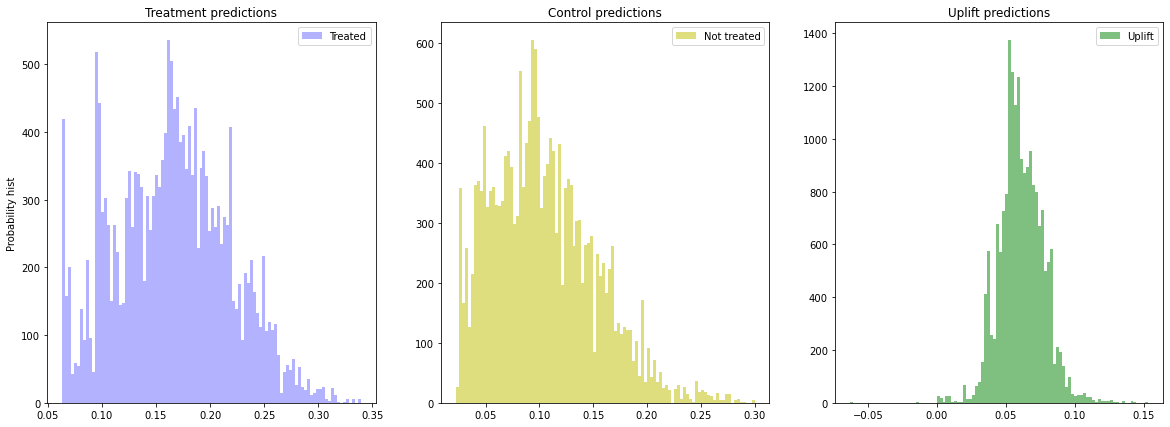

In [4]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [5]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-5-6e5ebc9c94ea>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


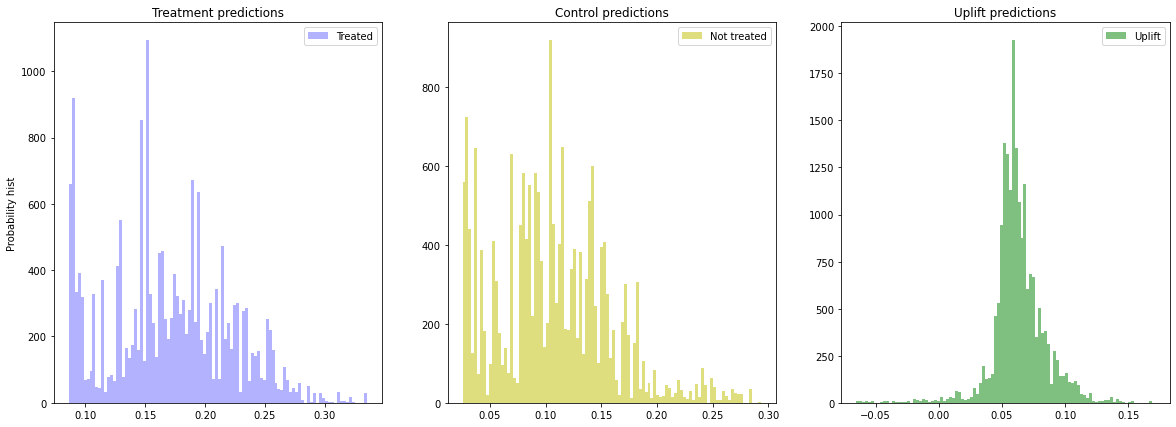

In [6]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [7]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.068239
2,TwoModels,0.058095
1,ClassTransformation,0.058019


In [8]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train[cat_features], prefix='cat_features')], 1)
features = [col for col in X_train_tree]

In [11]:
pip install causalml

  Running setup.py clean for causalml
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24572 sha256=d71ca5f73ff710917ca41f1ac938dcccd7685cf8952c7a8cb8ccb8773f38ee75
  Stored in directory: c:\users\sheno\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=40f9d3f9fd54c92c216994bc6dcccdcc212f923f1b90016d12932c924207d7af
  Stored in directory: c:\users\sheno\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=697d938ce0625868640ea52152cf9363bdb023c9099c60a8bf49424baad87a30
  Stored in directory: c:\users\sheno\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built pydotplus termcolor wrapt
Failed to build causalml
  Attempting uninstall: numpy
    Found exist

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\sheno\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\sheno\\AppData\\Local\\Temp\\pip-install-7jgkbvgd\\causalml\\setup.py'"'"'; __file__='"'"'C:\\Users\\sheno\\AppData\\Local\\Temp\\pip-install-7jgkbvgd\\causalml\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\sheno\AppData\Local\Temp\pip-wheel-gsk63jr0'
       cwd: C:\Users\sheno\AppData\Local\Temp\pip-install-7jgkbvgd\causalml\
  Complete output (76 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\causalml
  copying causalml\features.py -> build\lib.win-amd64-3.8\causalml
  copying causalml\match.py -> build\lib.win-amd64-3.8\causalml
  copying causalml\propensity.py

In [13]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml'